# Total COVID-19 deaths for different US states

Script produced by [Laurent Lessard](https://laurentlessard.com)

---

### Import data from covidtracking.com

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import datetime

mpl.rcParams['figure.dpi'] = 120

url = "https://covidtracking.com/api/states/daily.csv"
df_raw = pd.read_csv(url)

### Reformat data into convenient form

In [2]:
# aggregate by state
df = df_raw.pivot_table(index='date',values='death',columns='state')

# make the index a datetime object
df = df.set_index( pd.to_datetime(df.index, format="%Y%m%d") )

# sort the dates/times
df.sort_index(inplace=True)

# record the latest date
latest_date = df.index[-1]
latest_date_str = latest_date.strftime("%a %b %d, %Y")
print(latest_date_str)

Mon Oct 26, 2020


### List of states with the most total deaths

In [3]:
deaths_sorted = df.iloc[-1].sort_values(ascending=False)
deaths_sorted.head(20)

state
NY    25742.0
TX    17514.0
CA    17357.0
FL    16652.0
NJ    16292.0
MA     9881.0
IL     9792.0
PA     8673.0
GA     7827.0
MI     7552.0
AZ     5875.0
LA     5854.0
OH     5217.0
CT     4589.0
NC     4170.0
IN     4143.0
MD     4099.0
SC     3823.0
VA     3581.0
MS     3263.0
Name: 2020-10-26 00:00:00, dtype: float64

### List of states with the most daily deaths

In [4]:
daily_deaths_sorted = df.diff().iloc[-1].sort_values(ascending=False)
daily_deaths_sorted.head(15)

state
TN    32.0
MI    30.0
AR    21.0
SC    21.0
FL    20.0
GA    18.0
IL    17.0
MA    17.0
LA    17.0
IA    14.0
IN    13.0
NC    13.0
NY    12.0
CT    12.0
CA    12.0
Name: 2020-10-26 00:00:00, dtype: float64

### List of states with at least 100 deaths

In [5]:
states = df.columns[df.iloc[-1] >= 100]

for (i,c) in enumerate(states):
    print( c.ljust(4), end=' ')
    if (i+1) % 12 == 0:
        print()

AL   AR   AZ   CA   CO   CT   DC   DE   FL   GA   HI   IA   
ID   IL   IN   KS   KY   LA   MA   MD   ME   MI   MN   MO   
MS   MT   NC   ND   NE   NH   NJ   NM   NV   NY   OH   OK   
OR   PA   PR   RI   SC   SD   TN   TX   UT   VA   WA   WI   
WV   

### Plot shifted death toll for selected states

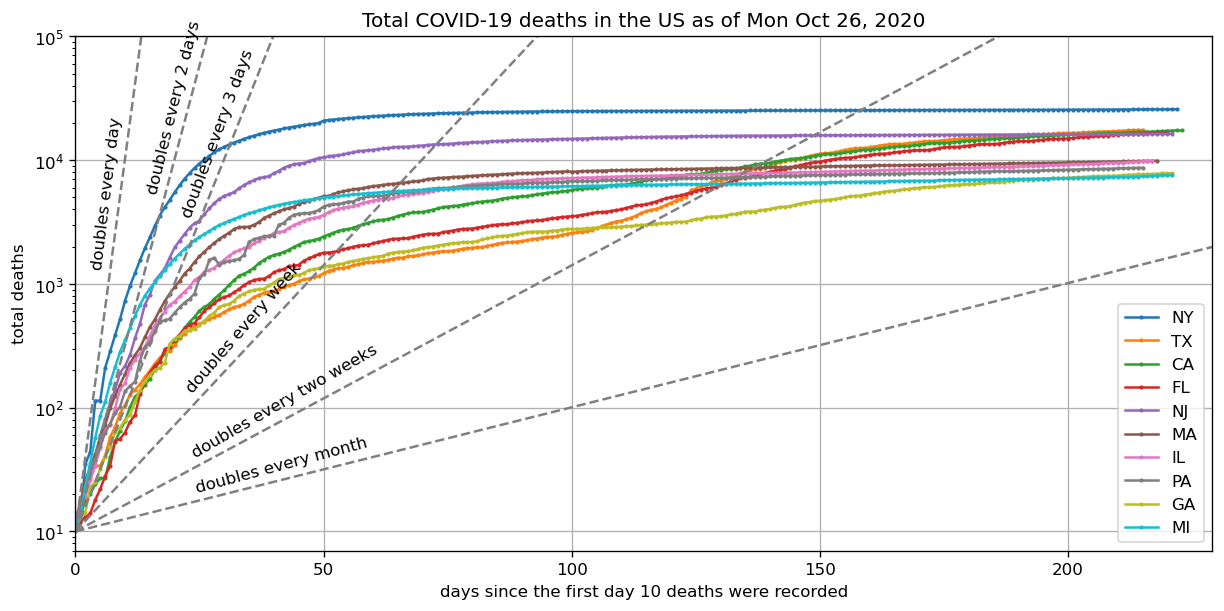

In [6]:
# function that shifts the data so everything starts from first min_deaths
def shift_data( states, min_deaths ):
    shifted_data = []
    for (c,data) in df[states].items():
        shifted_data.append( data[data >= min_deaths].reset_index(drop=True) )
    return shifted_data

# selected states
states = deaths_sorted[:10].index
# states = ['NY','NJ','MI','MA','IL','CA','CT','FL','WA','WI']
min_deaths = 10

# shift data so that index corresponds to days since min_death deaths.
shifted_data = shift_data( states, min_deaths )
data_len = max([len(dat) for dat in shifted_data])

xmax = data_len + 5

# merge into a single dataframe
dfx = pd.concat( shifted_data, axis=1 )

# make plot
ax = dfx.plot(title="Total COVID-19 deaths in the US as of %s" % latest_date_str, logy=True, figsize=(10,5), grid=True, marker='.', markersize=3);
ax.set_xlabel("days since the first day %g deaths were recorded" % min_deaths )
ax.set_ylabel("total deaths")
ax.set_ylim(min_deaths*.7,1e5)
ax.set_xlim(0,xmax);

# draw doubling lines (doubling every d days)
dvals = [1,2,3,7,14,30]    # values of doubling lines to draw (d)
dtxt = ["day", "2 days", "3 days", "week", "two weeks", "month"]
tloc = [7,18,25,25,25,25] # x-coordinate of text labels
for i,d in enumerate(dvals):
    tx = tloc[i]
    ty = min_deaths*(2**(tx/d))
    angle = np.arctan(ty/d * np.log(2))
    angle_screen = ax.transData.transform_angles(np.array([angle,]),np.array([[tx,ty]]),radians=True)[0]
    y = min_deaths*(2**(xmax/d))
    plt.plot([0,xmax],[min_deaths,y], '--', color='gray')
    ax.annotate("doubles every %s" % dtxt[i], xy=(tx,ty), xytext=(-5*np.sin(angle_screen),5*np.cos(angle_screen)),
                textcoords="offset points", rotation_mode='anchor', rotation=np.rad2deg(angle_screen))
plt.tight_layout(pad=0)
plt.savefig("figures/states_total_deaths_vs_time.png")

### Plot daily deaths

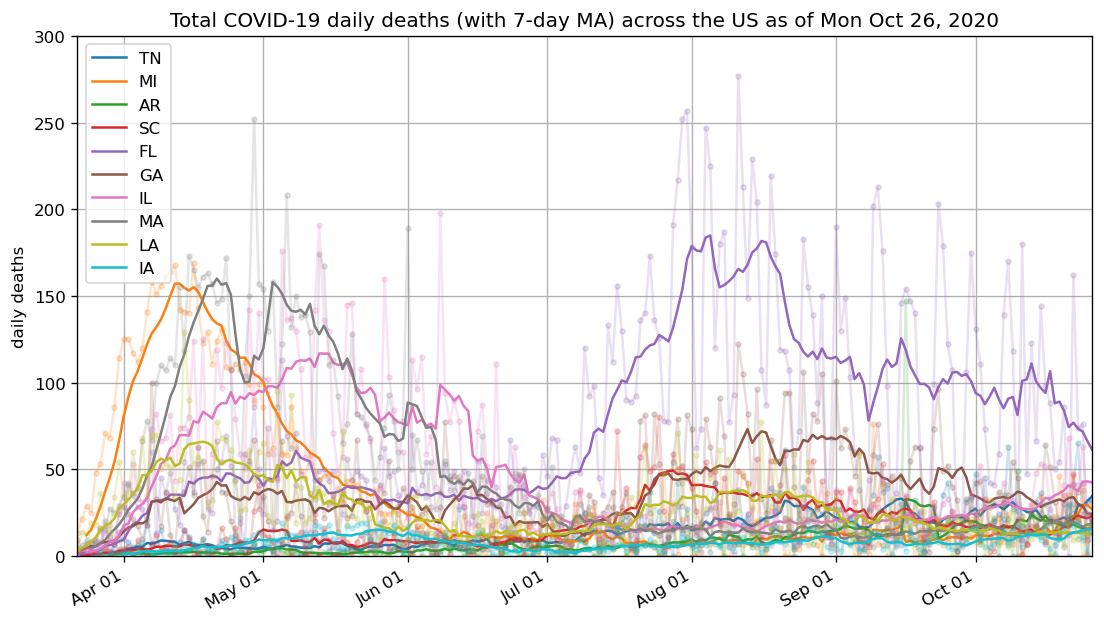

In [7]:
fig = plt.figure(figsize=(9,5))
ax = plt.gca()

# selected countries
states = daily_deaths_sorted[:10].index

for s in states:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot( df[s].diff(), marker=".", label=None, color=color, alpha=0.2 )
    plt.plot( df[s].diff().rolling(7).mean(), marker="", label=s, color=color, linewidth=1.5 )

# make plot
ax.set_title("Total COVID-19 daily deaths (with 7-day MA) across the US as of %s" % latest_date_str)
ax.legend(loc="upper left")
ax.set_ylabel("daily deaths")
ax.grid()
ax.set_xlim(xmin = datetime.date(2020, 3, 22), xmax = latest_date )
ax.set_ylim(ymin=0,ymax=300)

fig.autofmt_xdate()
date_format = "%b %d"
# ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter(date_format))
    
plt.tight_layout(pad=0)
plt.savefig("figures/states_daily_deaths_vs_time.png")

# Consider daily cases

In [8]:
# get state populations (2018 census)
url = "https://raw.githubusercontent.com/COVID19Tracking/associated-data/master/us_census_data/us_census_2018_population_estimates_states.csv"
df_pop = pd.read_csv(url, index_col="state", usecols=["state","state_name","population"])
df_pop.loc["DC","state_name"] = "Washington D.C."

# aggregate by state
dfc = df_raw.pivot_table(index='date',values='positive',columns='state')

# make the index a datetime object
dfc = dfc.set_index( pd.to_datetime(dfc.index, format="%Y%m%d") )

# sort the dates/times
dfc.sort_index(inplace=True)

# only keep states we have population data for
states = list(df_pop.index)
dfc = dfc[states]

# record the latest date
latest_date = dfc.index[-1]
latest_date_str = latest_date.strftime("%a %b %d, %Y")
print(latest_date_str)

# order states by most recent case rate
data_normalized = dfc.diff().rolling(7).mean().iloc[-1] / df_pop.population
state_order = data_normalized.sort_values().index

Mon Oct 26, 2020


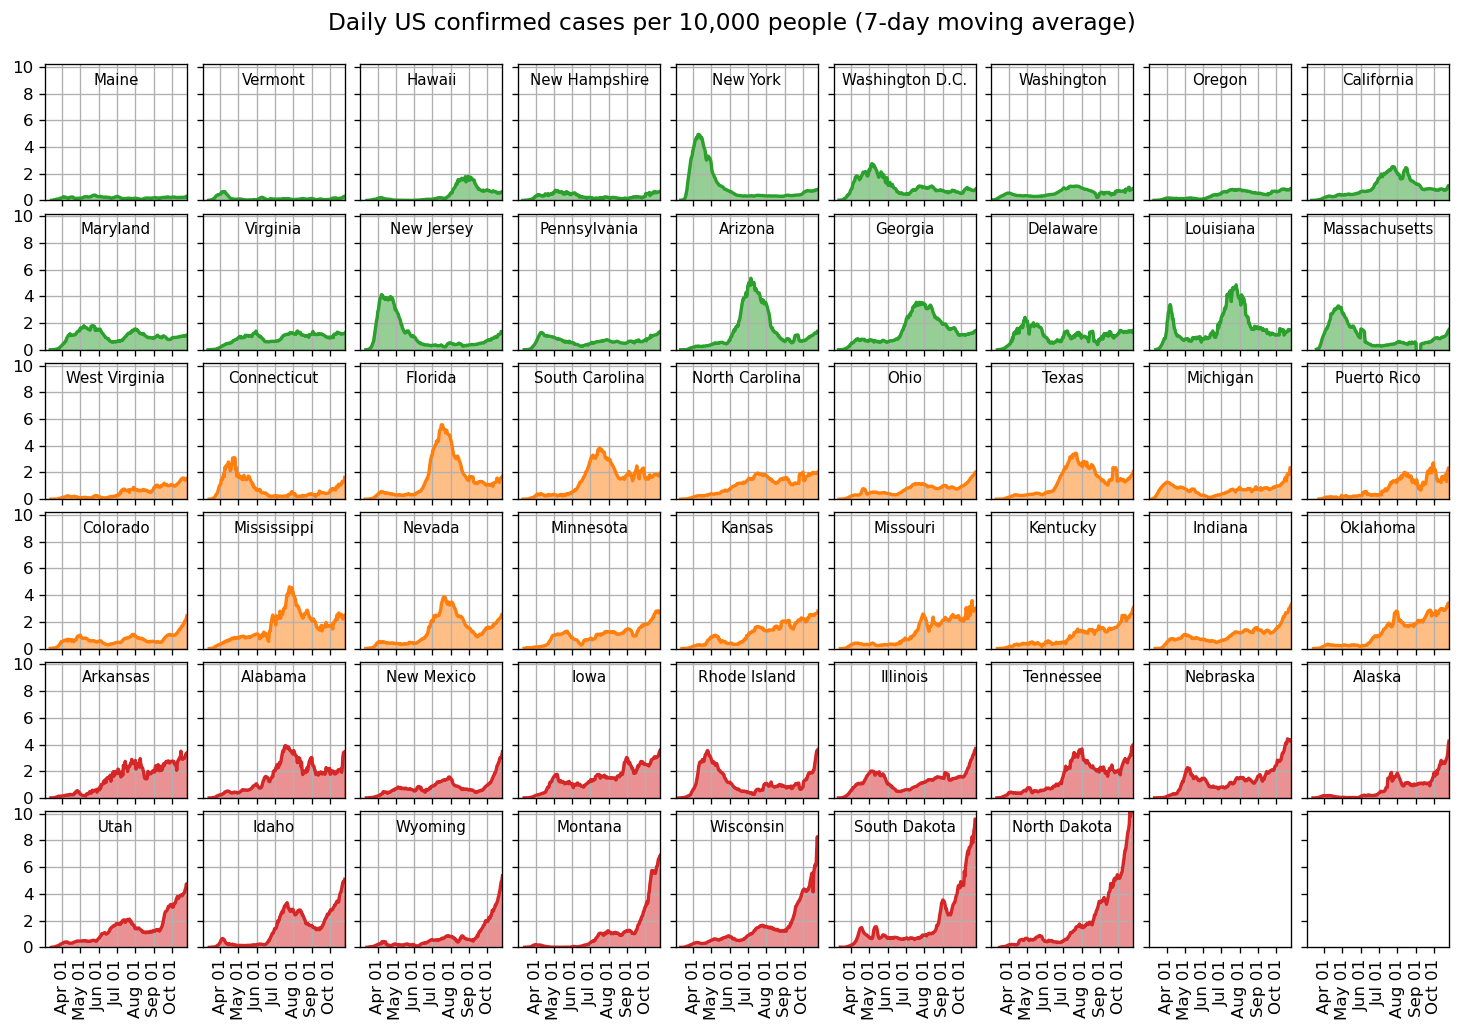

In [18]:
fig,axs = plt.subplots(6,9, figsize=(12,8), sharey=True, sharex=True)

# curves that go up and down (13)
cat1 = state_order[:18]

# curves that flattened but now are growing again (3)
cat2 = state_order[18:36]

# curves that just go straight up (5)
cat3 = state_order[36:]

pop_scale = 10000

for ix,state in enumerate(state_order):
    if ix < 18:
        col = "C2"
    elif ix < 36:
        col = "C1"
    else:
        col = "C3"
    
    ax = axs.reshape(-1)[ix]
    data = dfc[state]
    population = df_pop.population[state]
    state_name = df_pop.state_name[state]
    ax.fill_between( x=data.index, y1=data.diff().rolling(7).mean() / population * pop_scale, alpha=0.5, color=col )
    ax.plot( data.diff().rolling(7).mean() / population * pop_scale, linewidth=2, color=col )
    txt = ax.text(.5,.85, state_name,
            horizontalalignment='center',
            transform=ax.transAxes,
            fontsize=9)
    ax.grid()
    date_format = "%b %d"
    ax.xaxis.set_major_formatter(DateFormatter(date_format))
    ax.autoscale(enable=True, axis='x', tight=True)
    date_start = datetime.date(2020, 3, 3)
#     date_end   = datetime.date(2020, 7, 1)
    ax.set_xlim(xmin=date_start)
    
    months = mdates.MonthLocator()  # every month
    ax.xaxis.set_major_locator(months)
    
    ax.set_ylim(ymin=0,ymax=10.2)
    ax.set_yticks(range(0,11,2))

fig.autofmt_xdate(rotation=90, ha='center')
my_suptitle = fig.suptitle("Daily US confirmed cases per 10,000 people (7-day moving average)", fontsize=14, y=1.05)

plt.tight_layout(pad=0)
plt.savefig("figures/states_daily_cases_breakdown.png", dpi=fig.dpi, bbox_inches='tight', bbox_extra_artists=[my_suptitle])

## Heatmap of new cases by state

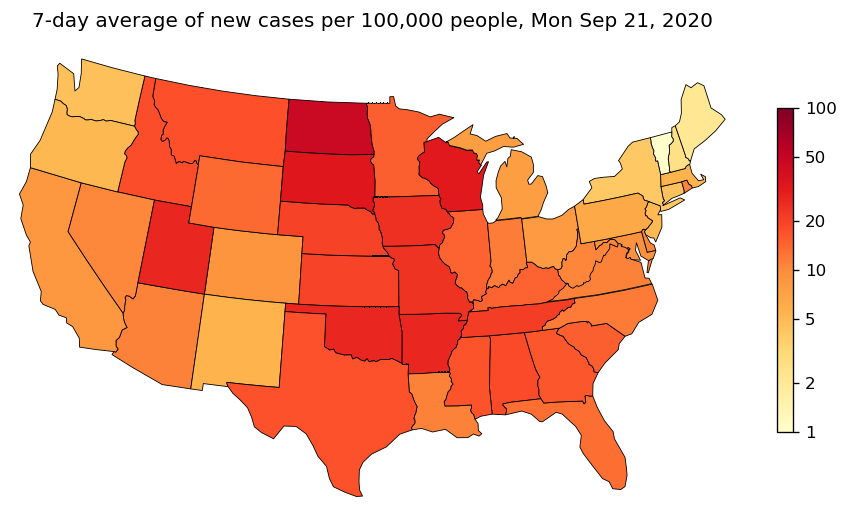

In [12]:
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors

LOG_SCALE = True

# get the normalized data and pick a colormap
data_normalized = ( dfc.diff().rolling(7).mean().iloc[-1] / df_pop.population * 100000 ).sort_values()
cmap = mpl.cm.get_cmap('YlOrRd')
cases_max = 100

fig = plt.figure(figsize=(7.5,4.5))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(), frameon=False)
ax.patch.set_visible(False)
ax.set_extent([-119, -74, 23, 51], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

for rec in shpreader.Reader(states_shp).records():

#     facecolor = (0.9375, 0.9375, 0.859375)
    edgecolor = 'black'
    linewidth = 0.5
    
    state = rec.attributes['postal']
    new_cases = data_normalized[state]
    
    if LOG_SCALE:
        facecolor = cmap( np.log10(new_cases) / np.log10(cases_max) )
    else:
        facecolor = cmap( new_cases / cases_max )
        
    ax.add_geometries([rec.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, linewidth=linewidth)

if LOG_SCALE:    
    ticks = [1,2,5,10,20,50,100]
    cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=1, vmax=cases_max, clip=False), cmap=cmap), ax=ax, shrink=0.6, ticks=ticks)
    cbar.ax.set_yticklabels(ticks)
    cbar.ax.minorticks_off()
else:
    fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=cases_max, clip=False), cmap=cmap), ax=ax, shrink=0.6)    

ax.set_title('7-day average of new cases per 100,000 people, %s' % latest_date_str)

plt.savefig("figures/states_daily_cases_map.png")

In [7]:
# import cartopy
# import cartopy.crs as ccrs
# import cartopy.io.shapereader as shpreader
# import matplotlib.patches as mpatches
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# import matplotlib.animation as animation

# LOG_SCALE = True

# def plot_data(date_str, data_normalized):
    
#     cmap = mpl.cm.get_cmap('YlOrRd')
#     cases_max = 100
    
#     fig = plt.figure(figsize=(7.5,4.5))
#     ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(), frameon=False)
#     ax.patch.set_visible(False)
#     ax.set_extent([-119, -74, 23, 51], ccrs.Geodetic())

#     shapename = 'admin_1_states_provinces_lakes_shp'
#     states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

#     for rec in shpreader.Reader(states_shp).records():

#         edgecolor = 'black'
#         linewidth = 0.5

#         state = rec.attributes['postal']
#         new_cases = data_normalized[state]

#         if LOG_SCALE:
#             facecolor = cmap( np.log10(new_cases) / np.log10(cases_max) )
#         else:
#             facecolor = cmap( new_cases / cases_max )

#         ax.add_geometries([rec.geometry], ccrs.PlateCarree(),
#                           facecolor=facecolor, edgecolor=edgecolor, linewidth=linewidth)

#     if LOG_SCALE:    
#         ticks = [1,2,5,10,20,50,100]
#         cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=1, vmax=cases_max, clip=False), cmap=cmap), ax=ax, shrink=0.6, ticks=ticks)
#         cbar.ax.set_yticklabels(ticks)
#         cbar.ax.minorticks_off()
#     else:
#         fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=cases_max, clip=False), cmap=cmap), ax=ax, shrink=0.6)    

#     ax.set_title('7-day average of new cases per 100,000 people, %s' % date_str)
    
#     # Used to return the plot as an image rray
#     fig.canvas.draw()       # draw the canvas, cache the renderer
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     plt.clf()
#     plt.close()

#     return image

In [8]:
# import imageio

# mpl.rcParams['figure.dpi'] = 300  # default is 120

# tinit = 39  # start on March 1
# tfinal = len(dfc) # go to today

# tinit = 98
# # tfinal = 125

# for t in range(tinit,tfinal):
#     print(f"{t} of {tfinal-1}")
#     date_str = dfc.index[t].strftime("%b %d, %Y")
#     data_normalized = (dfc.diff().rolling(7).mean().iloc[t] / df_pop.population * 100000).sort_values()
#     imageio.imsave( f'animation/img_{t:03}.png', plot_data(date_str, data_normalized) )

# # kwargs_write = {'fps':1.0, 'quantizer':'nq'}
# # imageio.mimsave('figures/states_daily_cases_map_animation.gif', imgs, fps=4)

98 of 168
99 of 168
100 of 168
101 of 168
102 of 168
103 of 168
104 of 168
105 of 168
106 of 168
107 of 168
108 of 168
109 of 168
110 of 168
111 of 168
112 of 168
113 of 168
114 of 168
115 of 168
116 of 168
117 of 168
118 of 168
119 of 168
120 of 168
121 of 168
122 of 168
123 of 168
124 of 168
125 of 168
126 of 168
127 of 168
128 of 168


<ipython-input-7-25fb570cb86d>:33: RuntimeWarning: divide by zero encountered in log10
  facecolor = cmap( np.log10(new_cases) / np.log10(cases_max) )


129 of 168
130 of 168
131 of 168
132 of 168
133 of 168
134 of 168
135 of 168
136 of 168
137 of 168
138 of 168
139 of 168
140 of 168
141 of 168
142 of 168
143 of 168
144 of 168
145 of 168
146 of 168
147 of 168
148 of 168
149 of 168
150 of 168
151 of 168
152 of 168
153 of 168
154 of 168
155 of 168
156 of 168
157 of 168
158 of 168
159 of 168
160 of 168
161 of 168
162 of 168
163 of 168
164 of 168
165 of 168
166 of 168
167 of 168
168 of 168
